<a href="https://colab.research.google.com/github/sdesai38/5105_SD/blob/main/FlightDelayProject5105HeatMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECGR 5105 Final Project: FAA Flight Delay Dataset
**Owen Bailey-Waltz (801488178)**
**Shamik Desai (801189802)**
[Link to dataset on Kaggle](https://www.kaggle.com/datasets/hrishitpatil/flight-data-2024)

In [ ]:
# import required packages, load data
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn import datasets, metrics
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import drive
from IPython.display import display

In [ ]:
# check for CUDA
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f'Now training on device {device}')

Now training on device cpu


In [ ]:
#!pip install kaggle

In [ ]:
# data import code (from Kaggle)
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "flight_data_2024.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "hrishitpatil/flight-data-2024",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md
)

print("First 5 records:")
display(df.head())

/tmp/ipython-input-2032139145.py:11: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'flight-data-2024' dataset.


/usr/local/lib/python3.12/dist-packages/kagglehub/pandas_datasets.py:91: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  result = read_function(


First 5 records:


,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,...,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2024,1,1,1,2024-01-01,9E,4814.0,JFK,"New York, NY",New York,...,0,136.0,122.0,84.0,509.0,0,0,0,0,0
1,2024,1,1,1,2024-01-01,9E,4815.0,MSP,"Minneapolis, MN",Minnesota,...,0,130.0,114.0,88.0,622.0,0,0,0,0,0
2,2024,1,1,1,2024-01-01,9E,4817.0,JFK,"New York, NY",New York,...,0,106.0,90.0,61.0,288.0,0,0,0,0,0
3,2024,1,1,1,2024-01-01,9E,4817.0,RIC,"Richmond, VA",Virginia,...,0,111.0,76.0,51.0,288.0,0,0,0,0,0
4,2024,1,1,1,2024-01-01,9E,4818.0,DTW,"Detroit, MI",Michigan,...,0,79.0,70.0,45.0,237.0,0,0,0,0,0


In [ ]:
# pre-process data with PyTorch
# note: flight number is not included since carrier and scheduled departure
# time both already convey this information
# serialize dates
flight_inputs = df.copy()
#fl_date = np.zeros(len(flight_inputs))
#for i in range(len(flight_inputs)):
#  fl_day = datetime.date(df['year'][i], df['month'][i],
#                         df['day_of_month'][i]) - datetime.date(2023,12,31)
#  fl_date[i] = fl_day.days
#display(fl_date)

In [ ]:
flight_inputs.pop('year')
flight_inputs.pop('fl_date')
flight_inputs.pop('origin_city_name')
flight_inputs.pop('origin_state_nm')
flight_inputs.pop('dest_city_name')
flight_inputs.pop('dest_state_nm')
flight_inputs.pop('cancellation_code')
flight_inputs
#flight_inputs.pop('month')
#flight_inputs.pop('day_of_month')
flight_inputs

,month,day_of_month,day_of_week,op_unique_carrier,op_carrier_fl_num,origin,dest,crs_dep_time,dep_time,dep_delay,...,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,1,1,1,9E,4814.0,JFK,DTW,1252,1247.0,-5.0,...,0,136.0,122.0,84.0,509.0,0,0,0,0,0
1,1,1,1,9E,4815.0,MSP,CLE,1015,1001.0,-14.0,...,0,130.0,114.0,88.0,622.0,0,0,0,0,0
2,1,1,1,9E,4817.0,JFK,RIC,1415,1411.0,-4.0,...,0,106.0,90.0,61.0,288.0,0,0,0,0,0
3,1,1,1,9E,4817.0,RIC,JFK,1650,1643.0,-7.0,...,0,111.0,76.0,51.0,288.0,0,0,0,0,0
4,1,1,1,9E,4818.0,DTW,MKE,1015,1010.0,-5.0,...,0,79.0,70.0,45.0,237.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7079076,12,31,2,YX,5857.0,MYR,LGA,1226,1220.0,-6.0,...,0,117.0,102.0,76.0,563.0,0,0,0,0,0
7079077,12,31,2,YX,5859.0,JFK,PWM,950,939.0,-11.0,...,0,89.0,72.0,51.0,273.0,0,0,0,0,0
7079078,12,31,2,YX,5859.0,PWM,JFK,1200,1153.0,-7.0,...,0,89.0,83.0,50.0,273.0,0,0,0,0,0
7079079,12,31,2,YX,5862.0,JFK,SYR,1530,1524.0,-6.0,...,0,89.0,81.0,42.0,209.0,0,0,0,0,0


In [ ]:
#serialize airline carrier codes and FAA airport codes
display(pd.Categorical(flight_inputs['op_unique_carrier']).codes)
display(pd.Categorical(flight_inputs['origin']).codes)
display(pd.Categorical(flight_inputs['dest']).codes)
flight_inputs['op_unique_carrier'] = pd.Categorical(flight_inputs['op_unique_carrier']).codes
flight_inputs['origin'] = pd.Categorical(flight_inputs['origin']).codes
flight_inputs['dest'] = pd.Categorical(flight_inputs['dest']).codes
flight_inputs

array([ 0,  0,  0, ..., 14, 14, 14], dtype=int8)

array([173, 227, 173, ..., 268, 173, 324], dtype=int16)

array([ 98,  67, 275, ..., 173, 324, 173], dtype=int16)

,month,day_of_month,day_of_week,op_unique_carrier,op_carrier_fl_num,origin,dest,crs_dep_time,dep_time,dep_delay,...,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,1,1,1,0,4814.0,173,98,1252,1247.0,-5.0,...,0,136.0,122.0,84.0,509.0,0,0,0,0,0
1,1,1,1,0,4815.0,227,67,1015,1001.0,-14.0,...,0,130.0,114.0,88.0,622.0,0,0,0,0,0
2,1,1,1,0,4817.0,173,275,1415,1411.0,-4.0,...,0,106.0,90.0,61.0,288.0,0,0,0,0,0
3,1,1,1,0,4817.0,275,173,1650,1643.0,-7.0,...,0,111.0,76.0,51.0,288.0,0,0,0,0,0
4,1,1,1,0,4818.0,98,217,1015,1010.0,-5.0,...,0,79.0,70.0,45.0,237.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7079076,12,31,2,14,5857.0,231,193,1226,1220.0,-6.0,...,0,117.0,102.0,76.0,563.0,0,0,0,0,0
7079077,12,31,2,14,5859.0,173,268,950,939.0,-11.0,...,0,89.0,72.0,51.0,273.0,0,0,0,0,0
7079078,12,31,2,14,5859.0,268,173,1200,1153.0,-7.0,...,0,89.0,83.0,50.0,273.0,0,0,0,0,0
7079079,12,31,2,14,5862.0,173,324,1530,1524.0,-6.0,...,0,89.0,81.0,42.0,209.0,0,0,0,0,0


In [ ]:
# look for null values and replace with mean
# chosen input features should not have any null values based on previous
# inspection of dataset
flight_inputs.isnull().sum() * 100 / flight_inputs.shape[0]

,0
month,0.000000
day_of_month,0.000000
day_of_week,0.000000
op_unique_carrier,0.000000
op_carrier_fl_num,0.000014
origin,0.000000
dest,0.000000
crs_dep_time,0.000000
dep_time,1.308913
dep_delay,1.313306


In [ ]:
# make sure everything is float32 for use in neural network applications
# fill null values in arr_delay before converting to tensor
flight_inputs['dep_delay'] = flight_inputs['dep_delay'].fillna(0)
flight_inputs['crs_elapsed_time'] = flight_inputs['crs_elapsed_time'].fillna(0)
flight_inputs['taxi_out'] = flight_inputs['taxi_out'].fillna(0)
flight_inputs = flight_inputs.astype(np.float32)
flight_inputs

,month,day_of_month,day_of_week,op_unique_carrier,op_carrier_fl_num,origin,dest,crs_dep_time,dep_time,dep_delay,...,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,1.0,1.0,1.0,0.0,4814.0,173.0,98.0,1252.0,1247.0,-5.0,...,0.0,136.0,122.0,84.0,509.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,4815.0,227.0,67.0,1015.0,1001.0,-14.0,...,0.0,130.0,114.0,88.0,622.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,4817.0,173.0,275.0,1415.0,1411.0,-4.0,...,0.0,106.0,90.0,61.0,288.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,4817.0,275.0,173.0,1650.0,1643.0,-7.0,...,0.0,111.0,76.0,51.0,288.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,4818.0,98.0,217.0,1015.0,1010.0,-5.0,...,0.0,79.0,70.0,45.0,237.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7079076,12.0,31.0,2.0,14.0,5857.0,231.0,193.0,1226.0,1220.0,-6.0,...,0.0,117.0,102.0,76.0,563.0,0.0,0.0,0.0,0.0,0.0
7079077,12.0,31.0,2.0,14.0,5859.0,173.0,268.0,950.0,939.0,-11.0,...,0.0,89.0,72.0,51.0,273.0,0.0,0.0,0.0,0.0,0.0
7079078,12.0,31.0,2.0,14.0,5859.0,268.0,173.0,1200.0,1153.0,-7.0,...,0.0,89.0,83.0,50.0,273.0,0.0,0.0,0.0,0.0,0.0
7079079,12.0,31.0,2.0,14.0,5862.0,173.0,324.0,1530.0,1524.0,-6.0,...,0.0,89.0,81.0,42.0,209.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# replace null delays with zero
delay_label_cols = ['security_delay','arr_delay', 'cancelled']
df[delay_label_cols] = df[delay_label_cols].fillna(0)
df.head()

,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,...,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2024,1,1,1,2024-01-01,9E,4814.0,JFK,"New York, NY",New York,...,0,136.0,122.0,84.0,509.0,0,0,0,0,0
1,2024,1,1,1,2024-01-01,9E,4815.0,MSP,"Minneapolis, MN",Minnesota,...,0,130.0,114.0,88.0,622.0,0,0,0,0,0
2,2024,1,1,1,2024-01-01,9E,4817.0,JFK,"New York, NY",New York,...,0,106.0,90.0,61.0,288.0,0,0,0,0,0
3,2024,1,1,1,2024-01-01,9E,4817.0,RIC,"Richmond, VA",Virginia,...,0,111.0,76.0,51.0,288.0,0,0,0,0,0
4,2024,1,1,1,2024-01-01,9E,4818.0,DTW,"Detroit, MI",Michigan,...,0,79.0,70.0,45.0,237.0,0,0,0,0,0


In [ ]:
# bring in our output features
cancelled = df['cancelled']
dep_delay = df['arr_delay']
security_delay = df['security_delay']


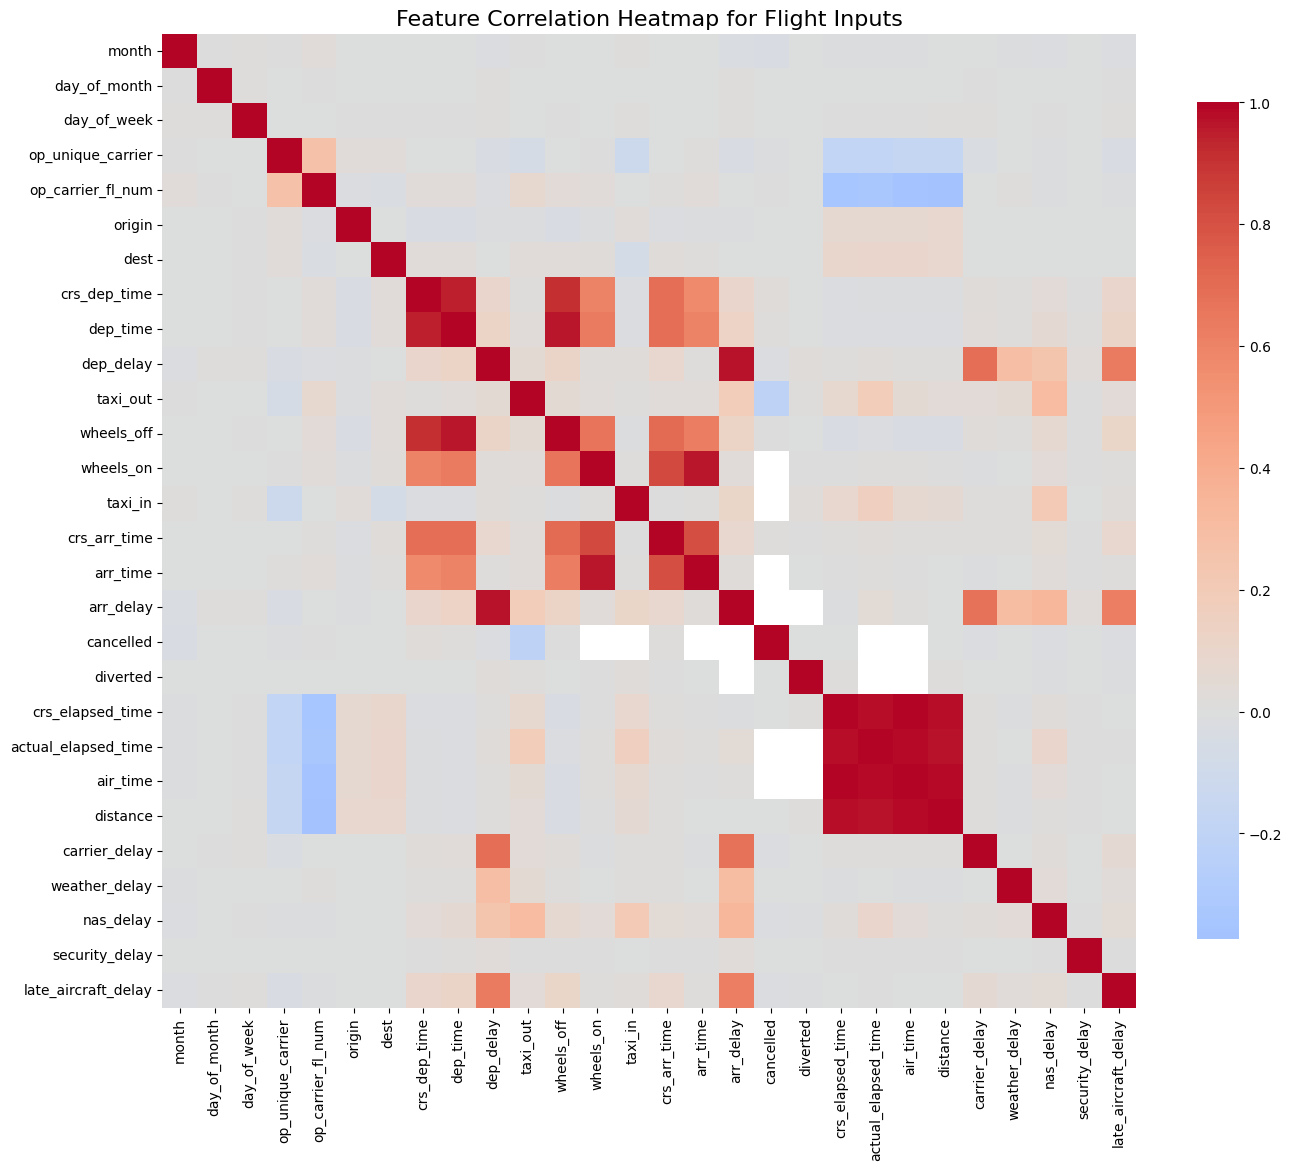

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Compute correlation matrix
corr_matrix = flight_inputs.corr(method='pearson')  # or 'spearman' if you prefer rank correlation

# Step 2: Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',      # diverging colormap for positive/negative correlations
    center=0,             # center at zero for balance
    annot=False,          # set True if you want correlation values displayed
    square=True,          # make cells square for readability
    cbar_kws={"shrink": .8}  # shrink color bar for aesthetics
)
plt.title("Feature Correlation Heatmap for Flight Inputs", fontsize=16)
plt.tight_layout()
plt.show()
